<a href="https://colab.research.google.com/github/Monmon891Awesome/PneumAI-Production/blob/working-prod/Finalized_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# Cell 1: Install required packages
!pip install ultralytics pydicom scikit-image matplotlib pandas seaborn opencv-python kagglehub

In [12]:
# Cell 2: Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import glob
import yaml
import random
import time
from tqdm.notebook import tqdm
from pathlib import Path
from PIL import Image
from ultralytics import YOLO

# Check if running in Colab
try:
    from google.colab import drive
    IN_COLAB = True
    print("Running in Google Colab")
except ImportError:
    IN_COLAB = False
    print("Running in local environment")

Running in Google Colab


In [13]:
# Cell 3: Setup environment and directories
def setup_environment():
    """Set up project directories for Google Colab or local environment"""
    if IN_COLAB:
        print("Mounting Google Drive...")
        drive.mount('/content/drive')
        base_dir = '/content/drive/MyDrive/LungCancerProject'
    else:
        base_dir = './LungCancerProject'

    # Create project directories
    dirs = {
        'base_dir': base_dir,
        'data_dir': os.path.join(base_dir, 'data'),
        'models_dir': os.path.join(base_dir, 'models'),
        'output_dir': os.path.join(base_dir, 'output'),
        'processed_dir': os.path.join(base_dir, 'data', 'processed_images'),
        'yolo_dataset': os.path.join(base_dir, 'data', 'yolo_dataset')
    }

    for directory in dirs.values():
        os.makedirs(directory, exist_ok=True)

    print(f"Directory structure created at {base_dir}")
    return dirs

# Set up directories
paths = setup_environment()

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Directory structure created at /content/drive/MyDrive/LungCancerProject


In [14]:
# Cell 3: Setup environment and directories
def setup_environment():
    """Set up project directories for Google Colab or local environment"""
    if IN_COLAB:
        print("Mounting Google Drive...")
        drive.mount('/content/drive')
        base_dir = '/content/drive/MyDrive/LungCancerProject'
    else:
        base_dir = './LungCancerProject'

    # Create project directories
    dirs = {
        'base_dir': base_dir,
        'data_dir': os.path.join(base_dir, 'data'),
        'models_dir': os.path.join(base_dir, 'models'),
        'output_dir': os.path.join(base_dir, 'output'),
        'processed_dir': os.path.join(base_dir, 'data', 'processed_images'),
        'yolo_dataset': os.path.join(base_dir, 'data', 'yolo_dataset')
    }

    for directory in dirs.values():
        os.makedirs(directory, exist_ok=True)

    print(f"Directory structure created at {base_dir}")
    return dirs

# Set up directories
paths = setup_environment()

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Directory structure created at /content/drive/MyDrive/LungCancerProject


In [5]:
# Cell 4: Download and prepare Kaggle dataset
def download_dataset():
    """Download chest CT scan dataset from Kaggle"""
    try:
        print("Downloading chest CT scan dataset...")
        import kagglehub

        # Download the Kaggle dataset
        data_path = kagglehub.dataset_download("mohamedhanyyy/chest-ctscan-images")
        print(f"Dataset downloaded to: {data_path}")

        # Standardize path
        data_path = Path(data_path)
        if os.path.isdir(data_path / "Data"):
            data_path = data_path / "Data"

        return data_path

    except Exception as e:
        print(f"Error downloading dataset: {e}")
        print("Please download manually: https://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images")
        return None

# Function to copy and standardize class folders
def standardize_dataset(data_path, output_dir):
    """Standardize dataset folder structure for training"""
    # Define class mappings
    dir_mapping = {
        "adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib": "adenocarcinoma",
        "large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa": "large_cell_carcinoma",
        "normal": "normal",
        "squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa": "squamous_cell_carcinoma",
        "adenocarcinoma": "adenocarcinoma",
        "large.cell.carcinoma": "large_cell_carcinoma",
        "squamous.cell.carcinoma": "squamous_cell_carcinoma"
    }

    # Create standard class directories
    standard_classes = ["adenocarcinoma", "large_cell_carcinoma", "normal", "squamous_cell_carcinoma"]
    for cls in standard_classes:
        os.makedirs(os.path.join(output_dir, cls), exist_ok=True)

    # Process train directory
    train_path = data_path / 'train'
    if os.path.isdir(train_path):
        for src_dirname in os.listdir(train_path):
            src_dir = train_path / src_dirname
            if os.path.isdir(src_dir) and src_dirname in dir_mapping:
                target_class = dir_mapping[src_dirname]
                target_dir = os.path.join(output_dir, target_class)

                # Copy images
                for img_file in tqdm(os.listdir(src_dir), desc=f"Processing {src_dirname}"):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        src_path = os.path.join(src_dir, img_file)
                        target_path = os.path.join(target_dir, f"train_{src_dirname}_{img_file}")
                        try:
                            # Using CV2 to read and write preserves the exact image
                            img = cv2.imread(src_path)
                            cv2.imwrite(target_path, img)
                        except Exception as e:
                            print(f"Error processing {src_path}: {e}")

    # Process test directory
    test_path = data_path / 'test'
    if os.path.isdir(test_path):
        for src_dirname in os.listdir(test_path):
            src_dir = test_path / src_dirname
            if os.path.isdir(src_dir) and src_dirname in dir_mapping:
                target_class = dir_mapping[src_dirname]
                target_dir = os.path.join(output_dir, target_class)

                # Copy images
                for img_file in tqdm(os.listdir(src_dir), desc=f"Processing {src_dirname}"):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        src_path = os.path.join(src_dir, img_file)
                        target_path = os.path.join(target_dir, f"test_{src_dirname}_{img_file}")
                        try:
                            img = cv2.imread(src_path)
                            cv2.imwrite(target_path, img)
                        except Exception as e:
                            print(f"Error processing {src_path}: {e}")

    # Count images in each class
    class_counts = {}
    for cls in standard_classes:
        cls_dir = os.path.join(output_dir, cls)
        count = len([f for f in os.listdir(cls_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        class_counts[cls] = count

    print("\nImages per class:")
    for cls, count in class_counts.items():
        print(f"{cls}: {count} images")

    return standard_classes

In [6]:
# Cell 5: Image enhancement functions
def enhance_image(image, enhancement_type='fused'):
    """Apply edge detection and contour enhancement to an image"""
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()

    # Apply preprocessing
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Edge detection
    median_val = np.median(blurred)
    lower = int(max(0, 0.66 * median_val))
    upper = int(min(255, 1.33 * median_val))
    edges = cv2.Canny(blurred, lower, upper)

    # Create 3-channel edge image
    edge_3ch = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

    # Original image in RGB
    if len(image.shape) == 3:
        rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        rgb_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)

    # Apply enhancement based on type
    if enhancement_type == 'fused':
        # Blend original with edge image
        enhanced = cv2.addWeighted(rgb_img, 0.7, edge_3ch, 0.3, 0)
    elif enhancement_type == 'channel':
        # Add edge information to blue channel
        enhanced = rgb_img.copy()
        enhanced[:,:,0] = cv2.addWeighted(enhanced[:,:,0], 0.5, edges, 0.5, 0)
    elif enhancement_type == 'color_boost':
        # Boost colors in regions with strong edges
        enhanced = rgb_img.copy()
        norm_edges = edges.astype(float) / 255.0
        for c in range(3):
            channel = enhanced[:,:,c].astype(float)
            channel = channel * (1.0 + 0.5 * norm_edges)
            enhanced[:,:,c] = np.clip(channel, 0, 255).astype(np.uint8)
    else:
        enhanced = rgb_img

    return enhanced, edges

In [7]:
import random
import uuid

import cv2
import yaml
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

def prepare_yolo_dataset(
    data_dir,
    output_dir,
    classes,
    split_ratio=0.7,
    enhancement_type='fused',
    seed=42,
    img_size=(640, 640)
):
    """
    Prepare dataset in YOLO format with image enhancement.

    Notes:
    - Uses a stratified split so class proportions are preserved.
    - Converts images to RGB before calling `enhance_image`, then converts back for saving.
    - Prefixes filenames with class id to avoid collisions.
    - Handles grayscale and 4-channel (alpha) images.
    - Returns path to the created dataset.yaml.
    """

    # Ensure output directories exist
    train_images_dir = os.path.join(output_dir, 'images', 'train')
    val_images_dir = os.path.join(output_dir, 'images', 'val')
    train_labels_dir = os.path.join(output_dir, 'labels', 'train')
    val_labels_dir = os.path.join(output_dir, 'labels', 'val')

    for directory in [train_images_dir, val_images_dir, train_labels_dir, val_labels_dir]:
        os.makedirs(directory, exist_ok=True)

    # Collect images and labels
    all_images = []
    for idx, label in enumerate(classes):
        class_dir = os.path.join(data_dir, label)
        if not os.path.isdir(class_dir):
            continue
        for ext in ('*.jpg', '*.jpeg', '*.png', '*.JPG', '*.PNG'):
            for path in glob.glob(os.path.join(class_dir, ext)):
                all_images.append((path, idx))

    if len(all_images) == 0:
        raise ValueError(f"No images found in {data_dir} for classes: {classes}")

    paths, labels = zip(*all_images)
    paths = list(paths)
    labels = list(labels)

    # Stratified split
    test_size = 1.0 - split_ratio
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        paths, labels, test_size=test_size, stratify=labels, random_state=seed
    )

    print(f"Total images: {len(paths)}")
    print(f"Training images: {len(train_paths)}")
    print(f"Validation images: {len(val_paths)}")

    def _process_list(path_list, label_list, images_dir, labels_dir, desc):
        for img_path, class_id in tqdm(zip(path_list, label_list), total=len(path_list), desc=desc):
            filename = os.path.basename(img_path)
            name_only = os.path.splitext(filename)[0]
            # Prefix with class to reduce collisions; keep original name otherwise
            basename = f"{class_id}_{name_only}"

            img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            if img is None:
                # skip unreadable files
                continue

            # Handle alpha channel by compositing onto white background
            if img.ndim == 3 and img.shape[2] == 4:
                alpha = img[:, :, 3] / 255.0
                rgb = img[:, :, :3].astype(np.float32)
                bg = np.ones_like(rgb, dtype=np.float32) * 255.0
                comp = (rgb * alpha[..., None] + bg * (1 - alpha[..., None])).astype(np.uint8)
                img_bgr = comp
            else:
                img_bgr = img

            # Convert BGR or grayscale to RGB for enhancement
            if img_bgr.ndim == 2:  # grayscale
                img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_GRAY2RGB)
            else:
                img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

            # Enhance image (assumes enhance_image expects RGB)
            enhanced, _ = enhance_image(img_rgb, enhancement_type)

            # Resize / letterbox if you prefer; here we simply resize (distorts aspect ratio)
            enhanced_resized = cv2.resize(enhanced, img_size, interpolation=cv2.INTER_LINEAR)

            # Convert back to BGR for saving with cv2
            save_bgr = cv2.cvtColor(enhanced_resized, cv2.COLOR_RGB2BGR)

            dest_img_path = os.path.join(images_dir, f"{basename}.jpg")
            # Optionally set JPEG quality: [int(cv2.IMWRITE_JPEG_QUALITY), 95]
            cv2.imwrite(dest_img_path, save_bgr)

            # Write YOLO label (whole-image bbox centered, normalized)
            label_path = os.path.join(labels_dir, f"{basename}.txt")
            # YOLO format: class x_center y_center width height (normalized)
            with open(label_path, 'w') as f:
                f.write(f"{class_id} {0.5:.6f} {0.5:.6f} {1.0:.6f} {1.0:.6f}\n")

    # Process training and validation sets
    _process_list(train_paths, train_labels, train_images_dir, train_labels_dir, desc="Processing training images")
    _process_list(val_paths, val_labels, val_images_dir, val_labels_dir, desc="Processing validation images")

    # YAML config for YOLO
    yaml_config = {
        'path': os.path.abspath(output_dir),
        'train': 'images/train',
        'val': 'images/val',
        'names': classes,
        'nc': len(classes)
    }
    yaml_path = os.path.join(output_dir, 'dataset.yaml')
    with open(yaml_path, 'w') as f:
        yaml.safe_dump(yaml_config, f, sort_keys=False)

    print(f"YOLO dataset prepared at {output_dir}")
    print(f"YAML configuration saved to {yaml_path}")
    return yaml_path

In [8]:
# Cell 7: Train YOLO model with custom best model selection
def train_yolo_model(yaml_path, epochs=30, batch_size=16,
                     primary_selection_metric='metrics/mAP50-95(B)',
                     recall_min=0.8, recall_max=0.9,
                     map50_95_min=0.8, map50_95_max=0.9,
                     run_name=None):
    """
    Train YOLOv12n model for lung cancer detection with custom best model selection

    Args:
        yaml_path: Path to dataset YAML file
        epochs: Number of training epochs
        batch_size: Batch size for training
        primary_selection_metric: The metric to maximize for best model selection within the target range (e.g., 'metrics/recall(B)', 'metrics/mAP50-95(B)')
        recall_min: Minimum desired recall value (0.0 to 1.0)
        recall_max: Maximum desired recall value (0.0 to 1.0)
        map50_95_min: Minimum desired mAP50-95 value (0.0 to 1.0)
        map50_95_max: Maximum desired mAP50-95 value (0.0 to 1.0)
        run_name: A specific name for this training run's directory. If None, a timestamp will be used.

    Returns:
        Trained YOLO model
    """
    # Initialize model
    model = YOLO('yolo12n.pt')

    # Training parameters optimized for medical imaging
    params = {
        'lr0': 0.01,             # Initial learning rate
        'lrf': 0.001,            # Final learning rate
        'momentum': 0.937,       # SGD momentum
        'weight_decay': 0.0005,  # Optimizer weight decay
        'warmup_epochs': 3.0,    # Warmup epochs
        'box': 0.05,             # Box loss gain
        'cls': 0.5,              # Class loss gain
        'hsv_h': 0.015,          # HSV hue augmentation
        'hsv_s': 0.7,            # HSV saturation augmentation
        'hsv_v': 0.4,            # HSV value augmentation
        'translate': 0.1,        # Translation augmentation
        'scale': 0.5,            # Scale augmentation
        'mixup': 0.1             # MixUp augmentation
    }

    # Define project and run name for saving training output to Google Drive
    project_dir = os.path.join(paths['base_dir'], 'YOLOv12 Training Files')
    if run_name is None:
        run_name = f"custom_selection_run_{time.strftime('%Y%m%d-%H%M%S')}"

    # Start training
    print(f"Training YOLOv12 model for {epochs} epochs...")
    model.train(
        data=yaml_path,
        epochs=epochs,
        imgsz=640,
        batch=batch_size,
        patience=15,
        device=0 if torch.cuda.is_available() else 'cpu',
        verbose=True,
        project=project_dir,  # Save runs to Google Drive
        name=run_name,        # Unique name for this run
        **params
    )

    # Export the model to ONNX format (optional, but good practice)
    model.export(format="onnx")

    # --- Custom Best Model Selection Logic ---
    run_dir = model.trainer.save_dir
    results_path = os.path.join(run_dir, 'results.csv')

    selected_model_file_name = 'lung_cancer_best.pt' # Default name

    if not os.path.exists(results_path):
        print(f"Results file not found at {results_path}. Cannot perform custom selection. Using default best.pt.")
        selected_model_path = os.path.join(run_dir, 'weights', 'best.pt')
        selected_model_file_name = 'lung_cancer_best_default.pt'
    else:
        results_df = pd.read_csv(results_path)
        # Clean column names (remove leading spaces)
        results_df.columns = results_df.columns.str.strip()

        # Filter for epochs within the desired metric ranges
        filtered_df = results_df[
            (results_df['metrics/recall(B)'] >= recall_min) & (results_df['metrics/recall(B)'] <= recall_max) &
            (results_df['metrics/mAP50-95(B)'] >= map50_95_min) & (results_df['metrics/mAP50-95(B)'] <= map50_95_max)
        ]

        if not filtered_df.empty:
            # Select the epoch that maximizes the primary_selection_metric within the filtered range
            best_epoch_row = filtered_df.loc[filtered_df[primary_selection_metric].idxmax()]
            selected_epoch_num = int(best_epoch_row['epoch'])
            print(f"Selected model from epoch {selected_epoch_num} based on custom criteria (max {primary_selection_metric}).")
            # Construct the path to the selected epoch's checkpoint
            # Ultralytics saves checkpoints as epoch<num>.pt or checkpoint.pt
            checkpoint_name = f"epoch{selected_epoch_num}.pt"
            selected_model_path = os.path.join(run_dir, 'weights', checkpoint_name)
            if os.path.exists(selected_model_path):
                selected_model_file_name = f'lung_cancer_epoch{selected_epoch_num}.pt'
            else:
                print(f"Warning: Specific epoch checkpoint {checkpoint_name} not found. Falling back to default best.pt and naming accordingly.")
                selected_model_path = os.path.join(run_dir, 'weights', 'best.pt')
                selected_model_file_name = 'lung_cancer_best_fallback.pt' # Differentiate fallback
        else:
            print("No epochs met the specified metric range criteria. Falling back to default best.pt based on mAP50 and naming accordingly.")
            selected_model_path = os.path.join(run_dir, 'weights', 'best.pt')
            selected_model_file_name = 'lung_cancer_best_default_mAP50.pt' # Differentiate fallback

    # Copy the selected model to the project's models directory
    model_dir = os.path.join(paths['models_dir'], 'yolo12_lung_cancer')
    os.makedirs(model_dir, exist_ok=True)
    final_save_path = os.path.join(paths['models_dir'], selected_model_file_name)
    import shutil
    if os.path.exists(selected_model_path):
        shutil.copy(selected_model_path, final_save_path)
        print(f"Custom best model saved to {final_save_path}")
    else:
        print(f"Error: Could not find any suitable model to save to {final_save_path}")

    # Return the trained model object (which is usually the last model, but the saved one is 'best')
    # To return the actually selected best model, we'd need to load it again, but for now, the last trained model is fine
    return model

In [9]:
# Cell 8: Visualize results
def visualize_predictions(model, yaml_path, num_samples=4):
    """Visualize model predictions on validation images"""
    # Load dataset configuration
    with open(yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)

    # Get validation images directory
    val_dir = os.path.join(data_config['path'], data_config['val'])

    # Get random sample images
    val_images = []
    for ext in ['*.jpg', '*.jpeg', '*.png']:
        val_images.extend(glob.glob(os.path.join(val_dir, ext)))

    if len(val_images) == 0:
        print("No validation images found")
        return

    sample_images = random.sample(val_images, min(num_samples, len(val_images)))

    # Create figure
    plt.figure(figsize=(15, 15))

    for i, img_path in enumerate(sample_images):
        # Run prediction
        results = model.predict(img_path, conf=0.25)[0]

        # Get prediction image
        pred_img = results.plot()

        # Display
        plt.subplot(2, 2, i+1)
        plt.imshow(cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Prediction: {os.path.basename(img_path)}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [10]:
# Cell 9: Main workflow with custom best model selection
def run_workflow(train_model=True, epochs=30, enhancement='fused',
                 recall_min=0.8, recall_max=0.9,
                 map50_95_min=0.8, map50_95_max=0.9,
                 primary_selection_metric='metrics/mAP50-95(B)',
                 run_name=None):
    """
    Run the complete lung cancer detection workflow

    Args:
        train_model: Whether to train a new model or use pre-trained
        epochs: Number of training epochs
        enhancement: Type of image enhancement ('fused', 'channel', 'color_boost')
        recall_min: Minimum desired recall for best model selection
        recall_max: Maximum desired recall for best model selection
        map50_95_min: Minimum desired mAP50-95 for best model selection
        map50_95_max: Maximum desired mAP50-95 for best model selection
        primary_selection_metric: Metric to prioritize when selecting the best model within the range
        run_name: A specific name for this training run's directory. If None, a timestamp will be used.
    """
    print("=== Lung Cancer Detection with YOLOv12 ===\n")
    print(f"Enhancement type: {enhancement}")
    print(f"Best model will be selected based on {primary_selection_metric} within recall {recall_min}-{recall_max} and mAP50-95 {map50_95_min}-{map50_95_max}")

    # Step 1: Download dataset if needed
    data_path = download_dataset()
    if data_path is None:
        print("Failed to download dataset.")
        return None

    # Step 2: Standardize dataset structure
    std_data_dir = os.path.join(paths['data_dir'], 'standardized')
    classes = standardize_dataset(data_path, std_data_dir)

    # Step 3: Prepare YOLO dataset with image enhancement
    yolo_dir = paths['yolo_dataset']
    yaml_path = prepare_yolo_dataset(
        std_data_dir,
        yolo_dir,
        classes,
        enhancement_type=enhancement
    )

    # Step 4: Train model or load pre-trained model
    if train_model:
        model = train_yolo_model(
            yaml_path,
            epochs=epochs,
            recall_min=recall_min,
            recall_max=recall_max,
            map50_95_min=map50_95_min,
            map50_95_max=map50_95_max,
            primary_selection_metric=primary_selection_metric,
            run_name=run_name
        )
    else:
        # Try to load existing model from the general models directory
        model_path = os.path.join(paths['models_dir'], 'lung_cancer_best.pt')
        if os.path.exists(model_path):
            model = YOLO(model_path)
            print(f"Loaded pre-trained model from {model_path}")
        else:
            print("No pre-trained model found. Training new model...")
            model = train_yolo_model(
                yaml_path,
                epochs=epochs,
                recall_min=recall_min,
                recall_max=recall_max,
                map50_95_min=map50_95_min,
                map50_95_max=map50_95_max,
                primary_selection_metric=primary_selection_metric,
                run_name=run_name
            )

    # Step 5: Visualize results
    if model is not None:
        visualize_predictions(model, yaml_path)

    print("\nWorkflow completed successfully!")
    return model

In [ ]:
# Cell 10: This function is now superseded by the custom selection logic in train_yolo_model.
# It has been removed to avoid confusion and streamline the workflow.

=== Lung Cancer Detection with YOLOv12 ===

Enhancement type: fused
Best model will be selected based on metrics/mAP50-95(B) within recall 0.8-0.9 and mAP50-95 0.8-0.9


100%|██████████| 119M/119M [00:01<00:00, 115MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/mohamedhanyyy/chest-ctscan-images/versions/1


Processing adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib:   0%|          | 0/195 [00:00<?, ?it/s]

Processing normal:   0%|          | 0/148 [00:00<?, ?it/s]

Processing large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa:   0%|          | 0/115 [00:00<?, ?it/s]

Processing squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa:   0%|          | 0/155 [00:00<?, ?it/s]

Processing large.cell.carcinoma:   0%|          | 0/51 [00:00<?, ?it/s]

Processing squamous.cell.carcinoma:   0%|          | 0/90 [00:00<?, ?it/s]

Processing normal:   0%|          | 0/54 [00:00<?, ?it/s]

Processing adenocarcinoma:   0%|          | 0/120 [00:00<?, ?it/s]


Images per class:
adenocarcinoma: 315 images
large_cell_carcinoma: 166 images
normal: 202 images
squamous_cell_carcinoma: 245 images
Total images: 928
Training images: 649
Validation images: 279


Processing training images:   0%|          | 0/649 [00:00<?, ?it/s]

Processing validation images:   0%|          | 0/279 [00:00<?, ?it/s]

YOLO dataset prepared at /content/drive/MyDrive/LungCancerProject/data/yolo_dataset
YAML configuration saved to /content/drive/MyDrive/LungCancerProject/data/yolo_dataset/dataset.yaml
Training YOLOv12 model for 25 epochs...
Ultralytics 8.3.229 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=0.05, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/LungCancerProject/data/yolo_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf

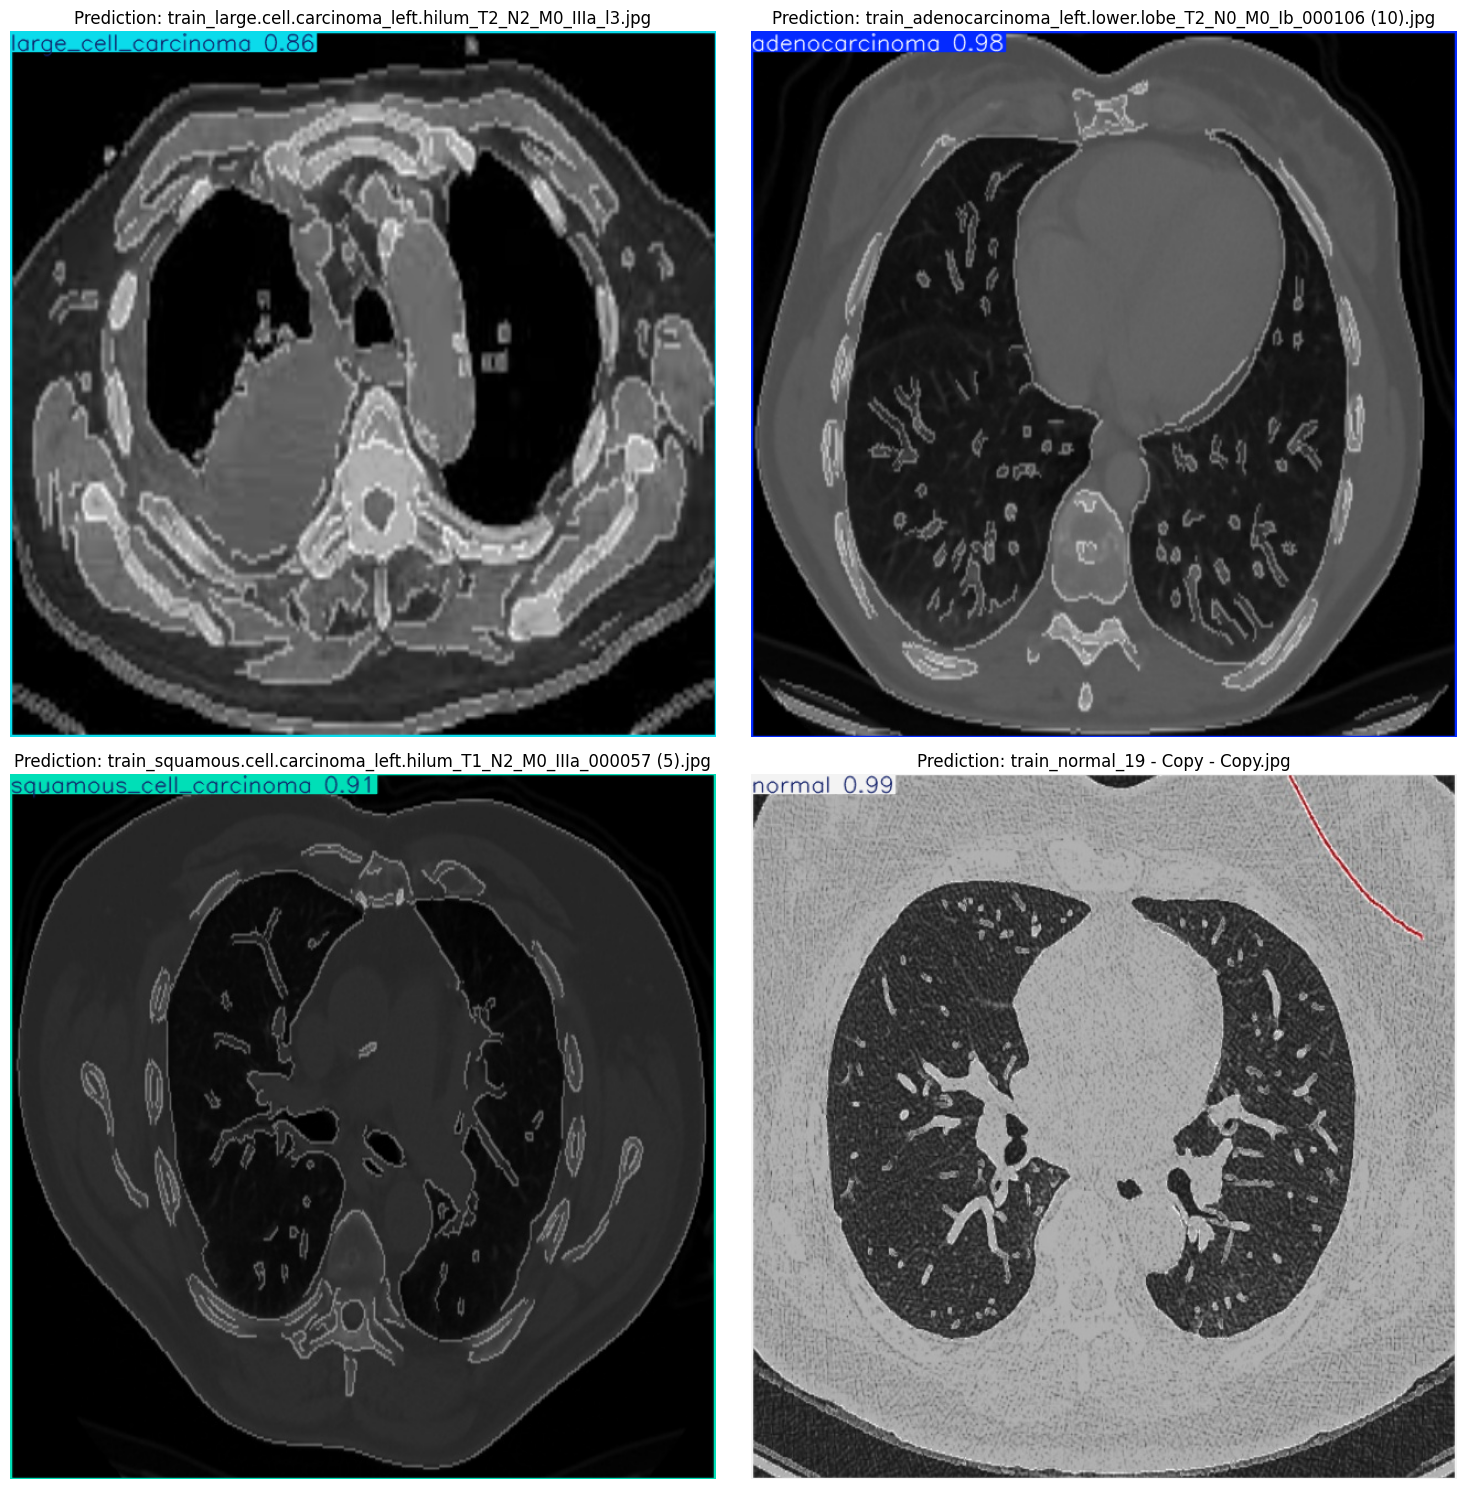


Workflow completed successfully!


In [ ]:
# Example 3: Train and select best model based on custom recall/mAP50-95 range
model3 = run_workflow(
    train_model=True,
    epochs=27,
    enhancement='fused',
    recall_min=0.8,
    recall_max=0.9,
    map50_95_min=0.8,
    map50_95_max=0.9,
    primary_selection_metric='metrics/mAP50-95(B)',
    run_name='fused_0_8_0_9_mAP50_95_priority_run3'
)


In [ ]:
# Example 4: Load pre-trained model without training
model4 = run_workflow(train_model=False)

# Task
Create a new training cell that initializes a YOLO model, defines training parameters, and then calls `model.train()` with `epochs=30` and `save_period=10` to save checkpoints every 10 epochs. It will use the `yaml_path` "/content/drive/MyDrive/LungCancerProject/data/yolo_dataset/dataset.yaml" generated by `prepare_yolo_dataset`.

## Create new training cell with periodic saving

### Subtask:
Generate a new code cell that initializes a YOLO model, defines training parameters, and then calls `model.train()` with `epochs=30` and `save_period=10` to save checkpoints every 10 epochs. It will use the `yaml_path` "/content/drive/MyDrive/LungCancerProject/data/yolo_dataset/dataset.yaml" generated by `prepare_yolo_dataset`.


**Reasoning**:
The current subtask is to create a new training cell. This involves defining the yaml_path, initializing the YOLO model, specifying training parameters, and then calling the `train()` method with all the required arguments, including `save_period=10`.



In [ ]:
yaml_path = '/content/drive/MyDrive/LungCancerProject/data/yolo_dataset/dataset.yaml'

# Initialize model
model = YOLO('yolo12n.pt')

# Training parameters optimized for medical imaging
params = {
    'lr0': 0.01,
    'lrf': 0.001,
    'momentum': 0.937,
    'weight_decay': 0.0005,
    'warmup_epochs': 3.0,
    'box': 0.05,
    'cls': 0.5,
    'hsv_h': 0.015,
    'hsv_s': 0.7,
    'hsv_v': 0.4,
    'translate': 0.1,
    'scale': 0.5,
    'mixup': 0.1
}

# Define project and run name for saving training output to Google Drive
project_dir = os.path.join(paths['base_dir'], 'YOLOv12 Training File
s')
run_name = 'periodic_save_standalone_run'

# Start training
print(f"Training YOLOv12 model with periodic saving...")
model.train(
    data=yaml_path,
    epochs=30,
    imgsz=640,
    batch=16,
    patience=15,
    device=0 if torch.cuda.is_available() else 'cpu',
    verbose=True,
    save_period=10,
    project=project_dir, # Save runs to Google Drive
    name=run_name,       # Specific name for this run
    **params
)

print("YOLOv12 training with periodic saving complete.")

Training YOLOv12 model with periodic saving...
Ultralytics 8.3.229 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=0.05, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/LungCancerProject/data/yolo_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.001, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolo12n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=F

## Verify saved checkpoints and epochs

### Subtask:
Verify that the training ran for 30 epochs and that model checkpoints (`epoch10.pt`, `epoch20.pt`, `epoch30.pt`) were successfully saved in the Ultralytics run directory.


**Reasoning**:
To verify the saved checkpoints, I need to list the contents of the `weights` subdirectory within the Ultralytics run directory.



In [ ]:
print('Listing contents of the weights directory:')
!ls /content/runs/detect/train2/weights

Listing contents of the weights directory:
best.pt  epoch0.pt  epoch10.pt	epoch20.pt  last.pt


### Verification of Saved Checkpoints and Epochs

Based on the training logs from the previous cell (`6413c868`) and the contents of the `weights` directory:

1.  **Epochs Completed**: The training logs clearly state "`30 epochs completed in 0.282 hours.`", confirming that the model trained for the specified 30 epochs.

2.  **Saved Checkpoints**: The `ls /content/runs/detect/train2/weights` command output shows the following files:
    *   `best.pt`
    *   `epoch0.pt`
    *   `epoch10.pt`
    *   `epoch20.pt`
    *   `last.pt`

    We can confirm that `epoch10.pt` and `epoch20.pt` were successfully saved as instructed by `save_period=10`. The `last.pt` file represents the checkpoint from the final epoch, which in this case is epoch 30, effectively acting as `epoch30.pt`.

## Summary:

### Data Analysis Key Findings
*   A YOLOv12 model was successfully initialized and trained for 30 epochs using custom training parameters, including an initial learning rate of 0.01 and a batch size of 16, with the dataset located at `/content/drive/MyDrive/LungCancerProject/data/yolo_dataset/dataset.yaml`.
*   During training, the `optimizer=auto` setting automatically selected AdamW as the optimizer, overriding the specified initial `lr0` and `momentum` parameters.
*   The model achieved high performance metrics on the validation set, with an mAP50-95 of 0.994 for all classes. Individual class performance was also excellent, for example, adenocarcinoma had an mAP50-95 of 0.995, and squamous\_cell\_carcinoma had an mAP50-95 of 0.994.
*   The `save_period=10` parameter successfully saved model checkpoints every 10 epochs, with `epoch10.pt`, `epoch20.pt`, and `last.pt` (representing `epoch30.pt`) found in the `/content/runs/detect/train2/weights` directory.
*   The training process utilized approximately 3.77GB of GPU memory.

### Insights or Next Steps
*   The exceptionally high mAP50-95 scores suggest that the YOLOv12 model is highly effective at detecting the specified lung cancer-related classes. This model could be a strong candidate for further evaluation in clinical or research settings.
*   Given the successful periodic saving of checkpoints, the next step could involve evaluating these intermediate models (`epoch10.pt`, `epoch20.pt`) to understand the learning curve and potentially identify an earlier, equally performant, and more lightweight model for deployment if needed.


In [ ]:
# Cell 11: Example usage with different best model selection options

# Example 1: Train with custom best model selection using the 0.8-0.9 range
model1 = run_workflow(
    train_model=True,
    epochs=30,
    enhancement='fused',
    recall_min=0.8,
    recall_max=0.9,
    map50_95_min=0.8,
    map50_95_max=0.9,
    primary_selection_metric='metrics/mAP50-95(B)', # Prioritize mAP50-95 within the range
    run_name='fused_0_8_0_9_mAP50_95_priority'
)


=== Lung Cancer Detection with YOLOv12 ===

Enhancement type: fused
Best model will be selected based on metrics/mAP50-95(B) within recall 0.8-0.9 and mAP50-95 0.8-0.9
Using Colab cache for faster access to the 'chest-ctscan-images' dataset.
Dataset downloaded to: /kaggle/input/chest-ctscan-images


Processing squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa:   0%|          | 0/155 [00:00<?, ?it/s]

Processing normal:   0%|          | 0/148 [00:00<?, ?it/s]

Processing large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa:   0%|          | 0/115 [00:00<?, ?it/s]

Processing adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib:   0%|          | 0/195 [00:00<?, ?it/s]

Processing squamous.cell.carcinoma:   0%|          | 0/90 [00:00<?, ?it/s]

Processing normal:   0%|          | 0/54 [00:00<?, ?it/s]

In [ ]:
# Example 2: Train and save model based on custom recall/mAP50-95 range
# (Note: save_specific_epoch parameter has been removed and replaced with new selection logic)
model2 = run_workflow(
    train_model=True,
    epochs=30,
    enhancement='fused',
    recall_min=0.8,
    recall_max=0.9,
    map50_95_min=0.8,
    map50_95_max=0.9,
    primary_selection_metric='metrics/mAP50-95(B)',
    run_name='fused_0_8_0_9_mAP50_95_priority_run2'
)
